In [1]:
import os
import pickle

import matplotlib.pyplot as plt
from seaborn import set_style
set_style("darkgrid")
import skimage as ski

from skimage.io import imread
from skimage.transform import resize
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pandas as pd
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix

In [2]:
from pynvml.smi import nvidia_smi
nvsmi = nvidia_smi.getInstance()
nvsmi.DeviceQuery('memory.free, memory.total')

{'gpu': [{'fb_memory_usage': {'total': 6144.0,
    'free': 5996.0,
    'unit': 'MiB'}}]}

In [4]:
import subprocess

try:
    subprocess.check_output('nvidia-smi')
    print('Nvidia GPU detected!')
except Exception: # this command not being found can raise quite a few different errors depending on the configuration
    print('No Nvidia GPU in system!')

Nvidia GPU detected!


In [6]:
!nvidia-smi

Sun Apr 14 10:29:49 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.86                 Driver Version: 551.86         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   54C    P0             25W /  122W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
nvsmi

In [3]:
# prepare data
input_dir = 'C:/Users/Jared/Documents/GitHub/my_road_project/assets/images/dataset/labeled/usa_combined'
categories = [str(x) for x in range(2)]

data = []
labels = []
for category_idx, category in enumerate(categories):
    for file in os.listdir(os.path.join(input_dir, category)):
        img_path = os.path.join(input_dir, category, file)
        img = imread(img_path)
        img = ski.color.rgb2gray(img)
        img = resize(img, (320, 320))
        data.append(img) #was img.flatten() for SVM
        labels.append(category_idx)

data = np.asarray(data)
labels = np.asarray(labels)

In [4]:
data[901]

array([[0.32332885, 0.32341573, 0.32911544, ..., 0.16525663, 0.23754267,
        0.2296572 ],
       [0.32841539, 0.32099354, 0.32635786, ..., 0.19863612, 0.20090955,
        0.2179734 ],
       [0.3193204 , 0.33070036, 0.3165998 , ..., 0.15092805, 0.15531574,
        0.2202947 ],
       ...,
       [0.22922862, 0.24556131, 0.2682508 , ..., 0.39458705, 0.13669149,
        0.06390743],
       [0.26442727, 0.24143757, 0.24037556, ..., 0.0828147 , 0.06454792,
        0.06389177],
       [0.19663848, 0.16289118, 0.15672388, ..., 0.06389171, 0.06389176,
        0.06389176]])

In [5]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True, stratify=labels)


In [6]:
#initialize the model

model = models.Sequential()


## adding our first convolutional layer

## Conv2D(32, specifies that we want a convolutional layer with depth 32
## (3,3) is our sliding grid size
## We're using the relu activation function
## and our images are a gray scale value for 28X28 pixels, hence the input_shape
model.add( layers.Conv2D( 32, (3,3), activation='relu', input_shape=(320,320,1,)  ) )


## adding our first Max Pooling layer
## MaxPooling2D((2,2) tells python we want to add
## a max pooling layer that uses a (2,2) square grid
## strides = 2, sets the stride value to 2
model.add( layers.MaxPooling2D( (2,2), strides = 2 ) )


## Add another layer, alternating between conv and pool
model.add( layers.Conv2D(64, (3,3), activation='relu'))
model.add( layers.MaxPooling2D( (2,2), strides=2) )


## Add another layer, alternating between conv and pool
model.add( layers.Conv2D(64, (3,3), activation='relu'))
model.add( layers.MaxPooling2D( (2,2), strides=2) )

## Add another layer, alternating between conv and pool
model.add( layers.Conv2D(64, (3,3), activation='relu'))
model.add( layers.MaxPooling2D( (2,2), strides=2) )


## Add another layer, alternating between conv and pool
model.add( layers.Conv2D(64, (3,3), activation='relu'))
model.add( layers.MaxPooling2D( (2,2), strides=2) )

## Add another layer, alternating between conv and pool
model.add( layers.Conv2D(64, (3,3), activation='relu'))
model.add( layers.MaxPooling2D( (2,2), strides=2) )





## Now we'll add the fully connected layer

## .Flatten() will flatten the data for us,
## meaning the last output data will turn into 
## a vector
model.add( layers.Flatten() )

## We've seen these before
## Then we add a single dense hidden layer
## This is 64 nodes high
model.add(layers.Dense(64, activation='relu'))


## Finally an output layer
model.add(layers.Dense(2, activation='softmax'))


#adam or rmsprop?

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

C:\Users\Jared\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [7]:
model.summary()


epochs=20

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 318, 318, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 159, 159, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 157, 157, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 78, 78, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 76, 76, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 36, 36, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 6, 6, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,586 (795.26 KB)

 Trainable params: 203,586 (795.26 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(x_train, 
                      to_categorical(y_train), 
                      epochs=epochs, 
                      batch_size=5,
                      validation_data=(x_test,to_categorical(y_test)),verbose = 1)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.5422 - loss: 0.6889 - val_accuracy: 0.5587 - val_loss: 0.6644
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.5926 - loss: 0.6670 - val_accuracy: 0.5678 - val_loss: 0.6787
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.6827 - loss: 0.6144 - val_accuracy: 0.4732 - val_loss: 0.7510
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.6915 - loss: 0.5977 - val_accuracy: 0.6591 - val_loss: 0.6312
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.7277 - loss: 0.5617 - val_accuracy: 0.6556 - val_loss: 0.6583
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.7409 - loss: 0.5325 - val_accuracy: 0.6659 - val_loss: 0.6741
Epoch 7/20
13/36 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7175 - loss: 0.5756

KeyboardInterrupt: 

In [ ]:
history_dict = history.history

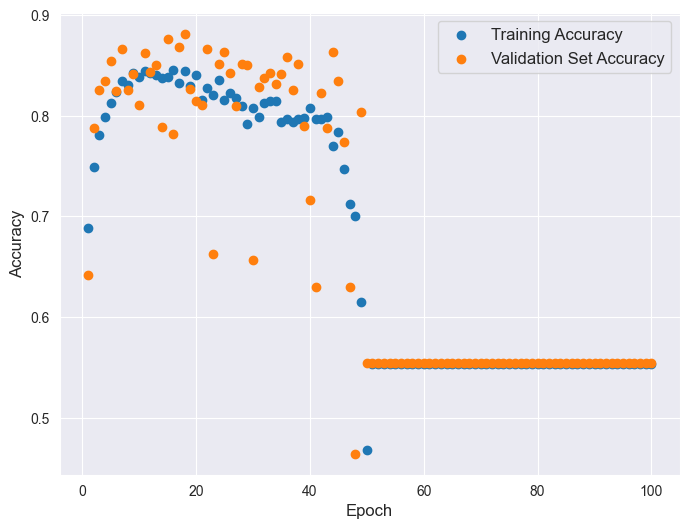

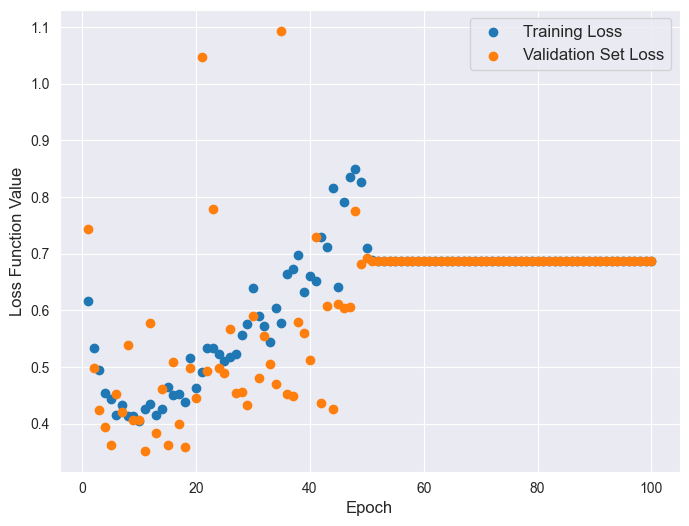

In [ ]:
plt.figure(figsize = (8,6))

plt.scatter(range(1,epochs+1), history_dict['accuracy'], label = "Training Accuracy")
plt.scatter(range(1,epochs+1), history_dict['val_accuracy'], label = "Validation Set Accuracy")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=12)

plt.show()


plt.figure(figsize = (8,6))

plt.scatter(range(1,epochs+1), history_dict['loss'], label = "Training Loss")
plt.scatter(range(1,epochs+1), history_dict['val_loss'], label = "Validation Set Loss")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss Function Value", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=12)

plt.show()

In [ ]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step


In [ ]:
y_pred[2]

1

In [ ]:
pd.DataFrame(confusion_matrix(y_test, y_pred), 
                columns=["predicted "+str(i) for i in range(2)],
                index=["actual "+str(i) for i in range(2)])

,predicted 0,predicted 1
actual 0,0,391
actual 1,0,486
